In [1]:
import random
import torch
from d2l import torch as d2l

In [4]:
tokens = d2l.tokenize(d2l.read_time_machine())
vocab = d2l.Vocab(tokens)
print(vocab._token_freqs[:10])

[('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443), ('my', 440)]


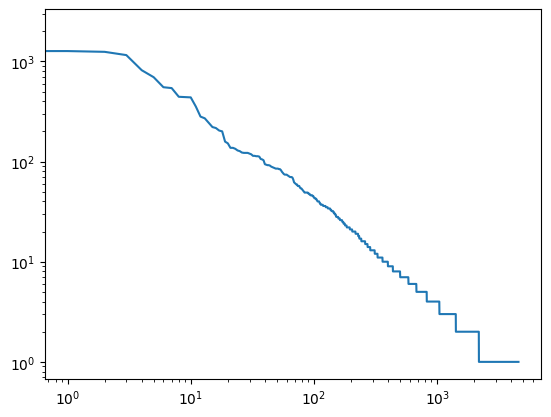

In [6]:
from matplotlib import pyplot as plt
freqs = [freq for token,freq in vocab._token_freqs]
plt.figure()
plt.plot(freqs)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [15]:
curpus = [token for line in tokens for token in line]
bigram_curpus = [pair for pair in zip(curpus[:-1],curpus[1:])]
bigram_vocab = d2l.Vocab(bigram_curpus)
bigram_freqs = [freq for token,freq in bigram_vocab._token_freqs]
print(bigram_vocab._token_freqs[:10])

[(('of', 'the'), 309), (('in', 'the'), 169), (('i', 'had'), 130), (('i', 'was'), 112), (('and', 'the'), 109), (('the', 'time'), 102), (('it', 'was'), 99), (('to', 'the'), 85), (('as', 'i'), 78), (('of', 'a'), 73)]


In [16]:
trigram_curpus = [pair for pair in zip(curpus[:-2],curpus[1:-1],curpus[2:])]
trigram_vocab = d2l.Vocab(trigram_curpus)
trigram_freqs = [freq for token,freq in trigram_vocab._token_freqs]
print(trigram_vocab._token_freqs[:10])

[(('the', 'time', 'traveller'), 59), (('the', 'time', 'machine'), 30), (('the', 'medical', 'man'), 24), (('it', 'seemed', 'to'), 16), (('it', 'was', 'a'), 15), (('here', 'and', 'there'), 15), (('seemed', 'to', 'me'), 14), (('i', 'did', 'not'), 14), (('i', 'saw', 'the'), 13), (('i', 'began', 'to'), 13)]


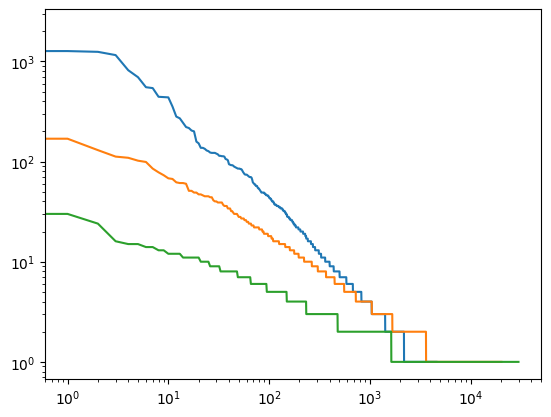

In [17]:
plt.figure()
plt.plot(freqs)
plt.plot(bigram_freqs)
plt.plot(trigram_freqs)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [21]:
def seq_data_iter_random(curpus,batch_size,num_steps):
    curpus = curpus[random.randint(0,num_steps-1):]
    num_subseqs = (len(curpus)-1) // num_steps
    initial_indices = list(range(0,num_steps*num_subseqs,num_steps))
    random.shuffle(initial_indices)

    def data(pos):
        return curpus[pos:pos+num_steps]
    num_batch = num_subseqs // batch_size
    for i in range(0,num_batch*batch_size,batch_size):
        initial_indices_per_batch = initial_indices[i:i+batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        y = [data(j+1) for j in initial_indices_per_batch]
        yield torch.tensor(X),torch.tensor(y)

In [23]:
seq =  list(range(0,35))
for x,y in seq_data_iter_random(seq,2,5):
    print('X:',x,'\nY:',y)

X: tensor([[21, 22, 23, 24, 25],
        [16, 17, 18, 19, 20]]) 
Y: tensor([[22, 23, 24, 25, 26],
        [17, 18, 19, 20, 21]])
X: tensor([[11, 12, 13, 14, 15],
        [ 6,  7,  8,  9, 10]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [ 7,  8,  9, 10, 11]])
X: tensor([[26, 27, 28, 29, 30],
        [ 1,  2,  3,  4,  5]]) 
Y: tensor([[27, 28, 29, 30, 31],
        [ 2,  3,  4,  5,  6]])


In [28]:
def seq_data_iter_sequential(curpus,batch_size,num_steps):
    offset = random.randint(0,num_steps-1)
    num_tokens = ((len(curpus)-offset-1)//batch_size)*batch_size
    Xs = torch.tensor(curpus[offset:offset+num_tokens]).reshape(batch_size,-1)
    Ys = torch.tensor(curpus[offset+1:offset+num_tokens+1]).reshape(batch_size,-1)
    num_batch = Xs.shape[1]//num_steps
    for i in range(0,num_batch*num_steps,num_steps):
        X = Xs[:,i:i+num_steps]
        Y = Ys[:,i:i+num_steps]
        yield X,Y

In [29]:
for x,y in seq_data_iter_sequential(seq,2,5):
    print('X:',x,'\nY:',y)

X: tensor([[ 0,  1,  2,  3,  4],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 1,  2,  3,  4,  5],
        [18, 19, 20, 21, 22]])
X: tensor([[ 5,  6,  7,  8,  9],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [23, 24, 25, 26, 27]])
X: tensor([[10, 11, 12, 13, 14],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [28, 29, 30, 31, 32]])


In [30]:
class SeqDataLoader():
    def __init__(self,num_steps,batch_size,use_random_iter,max_tokens):
        self.num_steps = num_steps
        self.batch_size = batch_size
        if use_random_iter:
            self.seq_data_iter_fn = seq_data_iter_random
        else:
            self.seq_data_iter_fn = seq_data_iter_sequential
        self.curpus,self.vocab = d2l.load_corpus_time_machine(max_tokens)
    
    def __iter__(self):
        return self.seq_data_iter_fn(self.curpus,self.batch_size,self.num_steps)

In [31]:
def load_data_time_machine(batch_size,num_steps,use_random_iter = False,max_tokens=10000):
    data_iter = SeqDataLoader(num_steps,batch_size,use_random_iter,max_tokens)
    return data_iter,data_iter.vocab